## GA convergence

Best solution found: 
X = [-1.06504711 -2.99896904]
F = [7.35802348]


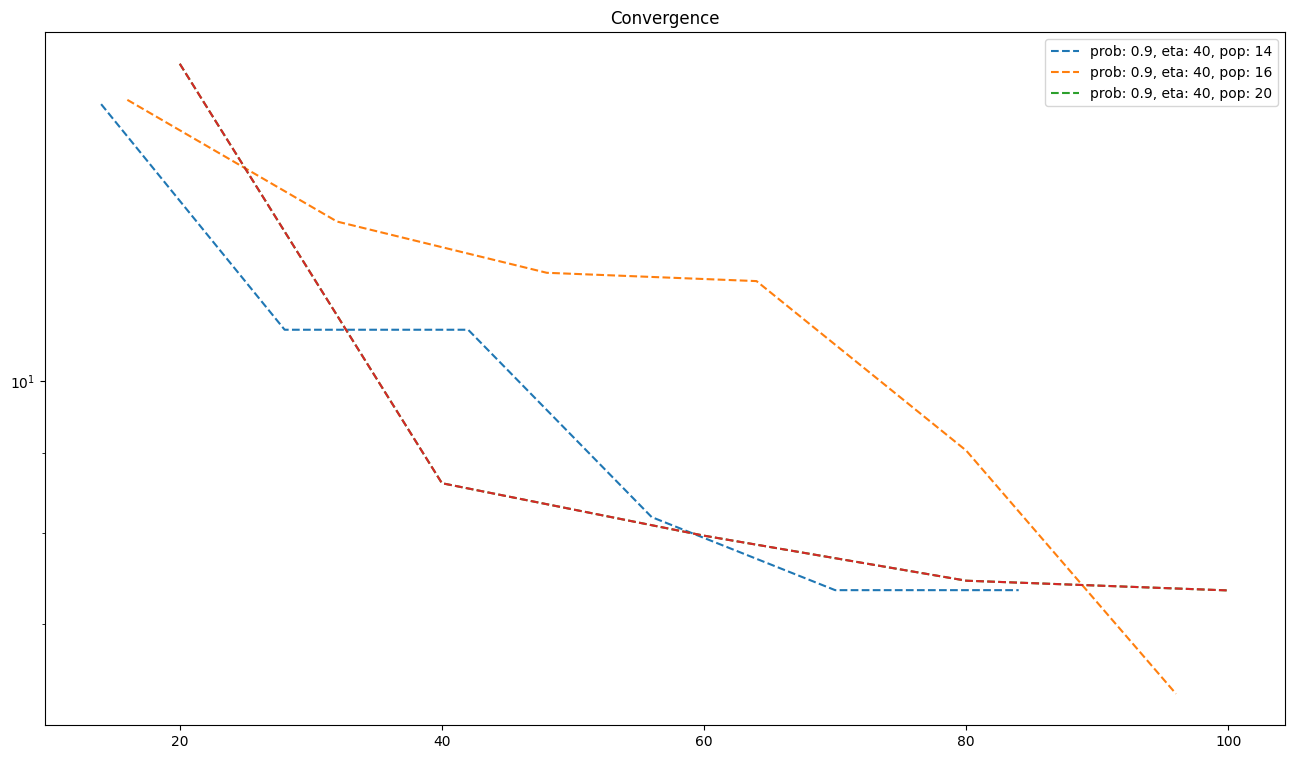

In [1]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.lhs import LHS
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.selection.rnd import RandomSelection
import numpy as np
import matplotlib.pyplot as plt

n_eval = 81
problem = get_problem("ackley")
probs = [0.9]
pops = [round(n_eval/6), round(n_eval/5), round(n_eval/4)]
etas = [40]
plt.figure(figsize=(16,9))

for pop in pops:
    for prob in probs:
        for eta in etas:
            algorithm = GA(
                pop_size=pop,
                sampling=LHS(),
                mutation=PolynomialMutation(prob=prob, eta=eta, at_least_once=True),
                selection = RandomSelection(),
                eliminate_duplicates=True)

            res = minimize(problem,
                        algorithm,
                        termination=("n_eval", n_eval),
                        seed=1,
                        verbose=False,
                        save_history=True)

            n_evals = np.array([e.evaluator.n_eval for e in res.history])
            opt = np.array([e.opt[0].F for e in res.history])
            
            plt.plot(n_evals, opt, "--", label=f"prob: {prob}, eta: {eta}, pop: {pop}")

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
plt.legend()
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.yscale("log")
plt.show()

## Extract optimization data

In [61]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.callback import Callback
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead


class HistCallback(Callback):
    def __init__(self) -> None:
        super().__init__()
        self.data["fmodel_hist"] = []
        self.data["x_hist"] = []
        self.data["A"] = []

    def notify(self, algorithm):
        self.data["fmodel_hist"].append(algorithm.pop.get("F"))
        self.data["x_hist"].append(algorithm.pop.get("X"))
        self.data["A"].append(algorithm.pop.get("A"))
        
class ElementwiseSphereWithConstraint(ElementwiseProblem):

    def __init__(self):
        xl = np.zeros(10)
        xl[0] = -5.0

        xu = np.ones(10)
        xu[0] = 5.0

        super().__init__(n_var=10, n_obj=1, n_ieq_constr=2, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = np.sum((x - 0.5) ** 2)
        out["G"] = np.column_stack([0.1 - out["F"], out["F"] - 0.5])
        out["A"] = [np.sum((x - 0.5) ** 2)]

problem = ElementwiseSphereWithConstraint()

algorithm = NelderMead()

res = minimize(problem,
               algorithm,
               termination=("n_gen", 150),
               callback=HistCallback(),
               seed=1,
               verbose=False)


In [62]:
f = np.concatenate(res.algorithm.callback.data["fmodel_hist"], axis=0)
a = np.concatenate(res.algorithm.callback.data["A"], axis=0)


In [63]:
print(a)
print(f)

[[7.358381  ]
 [1.81523611]
 [4.5516091 ]
 ...
 [0.10024402]
 [0.10054604]
 [0.10090386]]
[[7.358381  ]
 [1.81523611]
 [4.5516091 ]
 ...
 [0.10024402]
 [0.10054604]
 [0.10090386]]


In [65]:
np.concatenate((f, a), axis=1)

array([[7.358381  , 7.358381  ],
       [1.81523611, 1.81523611],
       [4.5516091 , 4.5516091 ],
       ...,
       [0.10024402, 0.10024402],
       [0.10054604, 0.10054604],
       [0.10090386, 0.10090386]])

## Restart optimizer

In [127]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
import numpy as np
from joblib import dump, load

In [118]:
p = get_problem("dtlz1^-1", n_var=3, n_obj=2)
a = NSGA2(pop_size=10)
r = minimize(p, a, verbose=False)

In [119]:
r.pop[0].X

array([1.        , 0.50002647, 0.49997086])

In [120]:
dump(r.pop, "C:\\Users\\brivio\\Desktop\\restart.pkl")
pop = load("C:\\Users\\brivio\\Desktop\\restart.pkl")

In [130]:
p1 = get_problem("dtlz1^-1", n_var=3, n_obj=2)
a1 = NSGA2(pop_size=10, sampling=pop)
r1 = minimize(p1, a1, verbose=False, save_history=True)

In [131]:
r1.history[0].pop[0].X

array([1.        , 0.50002647, 0.49997086])

In [132]:
set(r1.history[0].pop[0].X) == set(r.pop[0].X)

True